**Task1**

In [27]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import scipy.stats as st
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn import metrics

from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands

import datetime
import gc
from sklearn.metrics import r2_score

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns

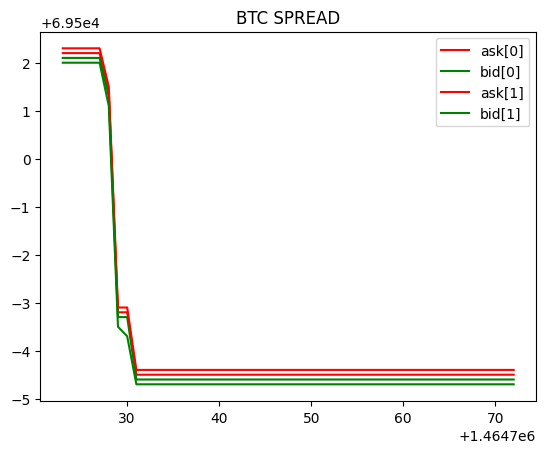

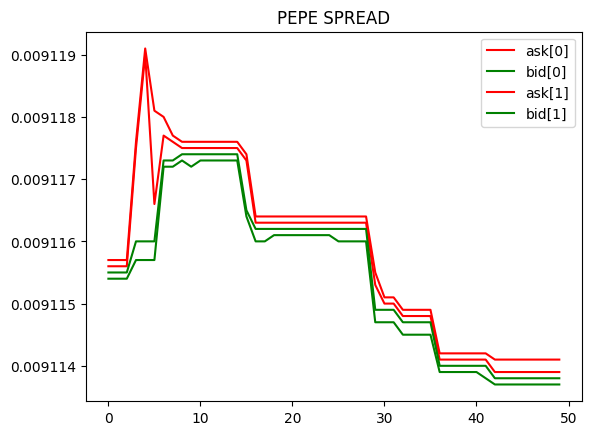

PEPE ASK: 130615431681.09996$ BID: 123103189289.50122$ SUM: 253718620970.6012$
BTC ASK: 1372536692515.7708$ BID: 1404299740636.2622$ SUM: 2776836433152.033$


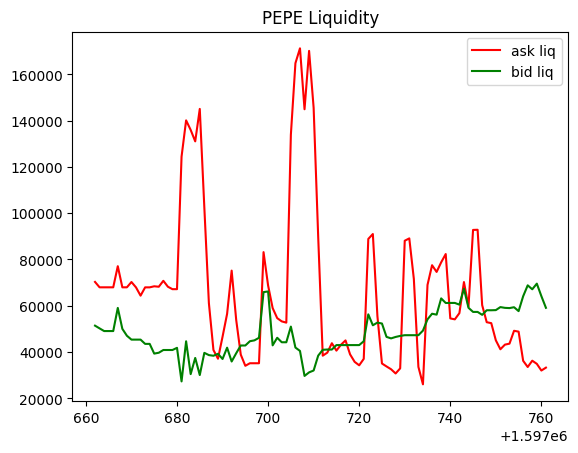

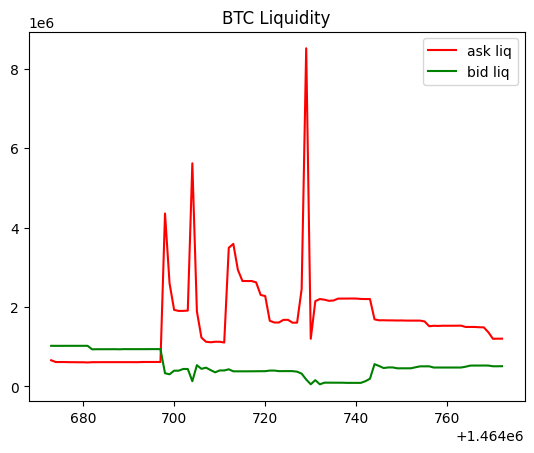

BTC BID: 606819.19$ ASK: 589494.51$ SUM: 1196313.69$
PEPE BID: 7088.86$ ASK: 6760.47$ SUM: 13849.33$
Correlation of liquidity density: -0.0236


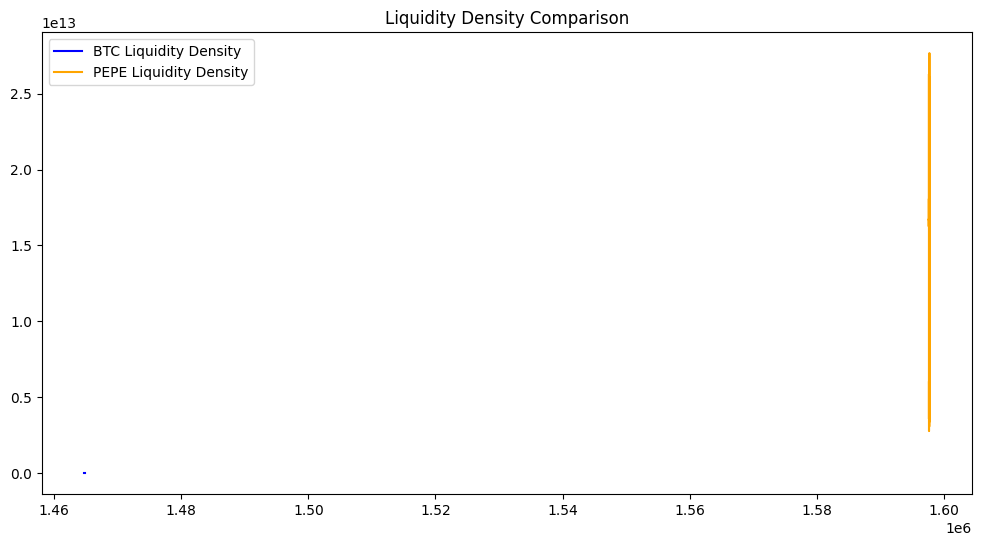

In [28]:
path0 = '/Users/maksim/Desktop/hw2/Py/binance-futures_book_snapshot_25_2024-11-01_1000PEPEUSDT.parquet'
path1 = '/Users/maksim/Desktop/hw2/Py/binance-futures_book_snapshot_25_2024-11-01_BTCUSDT.parquet'
path2 = '/Users/maksim/Desktop/hw2/Py/binance-futures_book_snapshot_25_2024-11-01_MEWUSDT.parquet'
path3 = '/Users/maksim/Desktop/hw2/Py/binance-futures_book_snapshot_25_2024-11-01_SOLUSDT.parquet'
path4 = '/Users/maksim/Desktop/hw2/Py/binance-futures_book_snapshot_25_2024-11-01_ETHUSDT.parquet'


df_pepe = pd.read_parquet(path0)
df_btc = pd.read_parquet(path1)
df_mew = pd.read_parquet(path2)
df_eth = pd.read_parquet(path4)
df_sol = pd.read_parquet(path3)


# Расчет mid-price и нормализация
df_btc['mid-price'] = (df_btc['asks[0].price'] + df_btc['bids[0].price']) / 2
df_pepe['mid-price'] = (df_pepe['asks[0].price'] + df_pepe['bids[0].price']) / 2

df_eth['mid-price'] = ( df_eth['asks[0].price'] + df_eth['bids[0].price'] ) / 2
df_mew['mid-price'] = ( df_mew['asks[0].price'] + df_mew['bids[0].price'] ) / 2
df_sol['mid-price'] = ( df_sol['asks[0].price'] + df_sol['bids[0].price'] ) / 2

scaler_btc = StandardScaler()
scaler_pepe = StandardScaler()
df_btc['mid-price_normalized'] = scaler_btc.fit_transform(df_btc[['mid-price']])
df_pepe['mid-price_normalized'] = scaler_pepe.fit_transform(df_pepe[['mid-price']])

# Визуализация спредов
T = 50
for i in range(2):
    plt.plot(df_btc[f'asks[{i}].price'][-T:], label=f'ask[{i}]', color='red')
    plt.plot(df_btc[f'bids[{i}].price'][-T:], label=f'bid[{i}]', color='green')
plt.title("BTC SPREAD")
plt.legend()
plt.show()

for i in range(2):
    plt.plot(df_pepe[f'asks[{i}].price'][:T], label=f'ask[{i}]', color='red')
    plt.plot(df_pepe[f'bids[{i}].price'][:T], label=f'bid[{i}]', color='green')
plt.title("PEPE SPREAD")
plt.legend()
plt.show()

# Расчет объемов ликвидности
btc_sum_usd_asks_value = 0
btc_sum_usd_bids_value = 0
pepe_sum_usd_asks_value = 0
pepe_sum_usd_bids_value = 0

lvls_num = 25
for i in range(lvls_num):
    btc_sum_usd_asks_value += df_btc[f'asks[{i}].price'] * df_btc[f'asks[{i}].amount']
    btc_sum_usd_bids_value += df_btc[f'bids[{i}].price'] * df_btc[f'bids[{i}].amount']
    pepe_sum_usd_asks_value += df_pepe[f'asks[{i}].price'] * df_pepe[f'asks[{i}].amount']
    pepe_sum_usd_bids_value += df_pepe[f'bids[{i}].price'] * df_pepe[f'bids[{i}].amount']

pepe_sum_usd_asks_value_abs = pepe_sum_usd_asks_value.sum()
pepe_sum_usd_bids_value_abs = pepe_sum_usd_bids_value.sum()
btc_sum_usd_asks_value_abs = btc_sum_usd_asks_value.sum()
btc_sum_usd_bids_value_abs = btc_sum_usd_bids_value.sum()

print(f"PEPE ASK: {pepe_sum_usd_asks_value_abs}$ BID: {pepe_sum_usd_bids_value_abs}$ SUM: {pepe_sum_usd_asks_value_abs + pepe_sum_usd_bids_value_abs}$")
print(f"BTC ASK: {btc_sum_usd_asks_value_abs}$ BID: {btc_sum_usd_bids_value_abs}$ SUM: {btc_sum_usd_asks_value_abs + btc_sum_usd_bids_value_abs}$")

# Визуализация изменения ликвидности
plt.plot(pepe_sum_usd_asks_value[-100:], color='red', label='ask liq')
plt.plot(pepe_sum_usd_bids_value[-100:], color='green', label='bid liq')
plt.legend()
plt.title("PEPE Liquidity")
plt.show()

plt.plot(btc_sum_usd_asks_value[-100:], color='red', label='ask liq')
plt.plot(btc_sum_usd_bids_value[-100:], color='green', label='bid liq')
plt.legend()
plt.title("BTC Liquidity")
plt.show()

# Дополнительные статистические расчеты
btc_ask = df_btc['asks[0].amount'] * df_btc['asks[0].price']
btc_bid = df_btc['bids[0].amount'] * df_btc['bids[0].price']
pepe_ask = df_pepe['asks[0].amount'] * df_pepe['asks[0].price']
pepe_bid = df_pepe['bids[0].amount'] * df_pepe['bids[0].price']

print(f"BTC BID: {round(btc_bid.mean(), 2)}$ ASK: {round(btc_ask.mean(), 2)}$ SUM: {round(btc_ask.mean() + btc_bid.mean(), 2)}$")
print(f"PEPE BID: {round(pepe_bid.mean(), 2)}$ ASK: {round(pepe_ask.mean(), 2)}$ SUM: {round(pepe_ask.mean() + pepe_bid.mean(), 2)}$")

# Плотность ликвидности: сумма объемов первых уровней деленная на разницу цен между ними (спред)
df_btc['liquidity_density'] = (df_btc['asks[0].amount'] + df_btc['bids[0].amount']) / (df_btc['asks[0].price'] - df_btc['bids[0].price'])
df_pepe['liquidity_density'] = (df_pepe['asks[0].amount'] + df_pepe['bids[0].amount']) / (df_pepe['asks[0].price'] - df_pepe['bids[0].price'])

# Рассчитываем корреляцию плотности ликвидности между BTC и PEPE
liquidity_density_corr = df_btc['liquidity_density'].corr(df_pepe['liquidity_density'])
print(f'Correlation of liquidity density: {liquidity_density_corr:.4f}')

# Графическое сравнение плотности ликвидности для наглядности
plt.figure(figsize=(12, 6))
plt.plot(df_btc['liquidity_density'][-100:], label='BTC Liquidity Density', color='blue')
plt.plot(df_pepe['liquidity_density'][-100:], label='PEPE Liquidity Density', color='orange')
plt.title('Liquidity Density Comparison')
plt.legend()
plt.show()



In [29]:
#объединение ( 1 ) и ( 2 )
#shifts = [10000, 20000, 51000] 

correlations = {}

# Сортируем DataFrame по local_timestamp
#for shift in shifts:
shift = 20000 
#for df1, name1 in [(df_btc, 'BTC'), (df_eth, 'ETH'), (df_pepe, 'PEPE'), (df_mew, 'MEW'), (df_sol, 'SOL')]:
#    for df2, name2 in [(df_btc, 'BTC'), (df_eth, 'ETH'), (df_pepe, 'PEPE'), (df_mew, 'MEW'), (df_sol, 'SOL')]:
df1, name1 = df_pepe, 'PEPE'
#df2, name2 = df_sol, 'SOL'
for df2, name2 in [(df_btc, 'BTC'), (df_eth, 'ETH'), (df_mew, 'MEW'), (df_sol, 'SOL')]:
    if name1 != name2:
        df1_sorted = df1.sort_values(by='local_timestamp').copy()
        df2_sorted = df2.sort_values(by='local_timestamp').copy()

                # Сдвиг mid-price
        df1_sorted['mid-price_shifted'] = df1_sorted['mid-price'].shift(shift)
        df1_sorted['price_diff'] = df1_sorted['mid-price'].diff()
        df2_sorted['price_diff'] = df2_sorted['mid-price'].diff()

                # Объединение с условием разницы во времени не более 50
        merged = pd.merge_asof(
            df1_sorted, 
            df2_sorted, 
            on='local_timestamp', 
            direction='nearest', 
            tolerance=50,
            suffixes=('_df1', '_df2')
        )

                # Удаляем строки с пропусками после объединения
        merged = merged.dropna(subset=['mid-price_shifted', 'mid-price_df2', 'price_diff_df2'])

        if not merged.empty:
                    # Расчет корреляций
            mid_price_corr = merged['mid-price_df2'].corr(merged['mid-price_shifted'])
            price_diff_corr = merged['price_diff_df2'].corr(merged['price_diff_df1'])

        correlations[(name1, name2, shift, 'mid-price')] = mid_price_corr
        correlations[(name1, name2, shift, 'price_diff')] = price_diff_corr

                    
# Печать результатов
for key, value in correlations.items():
    print(f'Корреляция между {key[0]} и {key[1]} при сдвиге {key[2]} ({key[3]}): {value:.4f}')
df_corr = pd.DataFrame(
    [(key[0], key[1], key[2], value) for key, value in correlations.items()],
    columns=['df1', 'df2', 'Shift', 'Correlation']
)

significant_threshold = 0.5  # Порог для значимости аутпута
significant_corrs = df_corr[df_corr['Correlation'].abs() >= significant_threshold]

print("Значимые корреляции:")
print(significant_corrs)

# Группировка данных для определения доминирующих инструментов
grouped_corrs = significant_corrs.groupby(['df1', 'df2'])['Correlation'].max().reset_index()

print("\nИнструменты-лидеры:")
leaders = grouped_corrs.sort_values(by='Correlation', ascending=False).head(5)
print(leaders)

# Из анализа в Price Discovery я сделал вывод что pepe и sol сильно коррелируют и sol mid-price можно 
#использовать как feature для модели из задания 4



Корреляция между PEPE и BTC при сдвиге 20000 (mid-price): 0.7779
Корреляция между PEPE и BTC при сдвиге 20000 (price_diff): 0.5010
Корреляция между PEPE и ETH при сдвиге 20000 (mid-price): 0.6236
Корреляция между PEPE и ETH при сдвиге 20000 (price_diff): 0.4547
Корреляция между PEPE и MEW при сдвиге 20000 (mid-price): 0.4090
Корреляция между PEPE и MEW при сдвиге 20000 (price_diff): 0.5183
Корреляция между PEPE и SOL при сдвиге 20000 (mid-price): 0.8030
Корреляция между PEPE и SOL при сдвиге 20000 (price_diff): 0.3851
Значимые корреляции:
    df1  df2  Shift  Correlation
0  PEPE  BTC  20000     0.777871
1  PEPE  BTC  20000     0.500963
2  PEPE  ETH  20000     0.623560
5  PEPE  MEW  20000     0.518297
6  PEPE  SOL  20000     0.802964

Инструменты-лидеры:
    df1  df2  Correlation
3  PEPE  SOL     0.802964
0  PEPE  BTC     0.777871
1  PEPE  ETH     0.623560
2  PEPE  MEW     0.518297


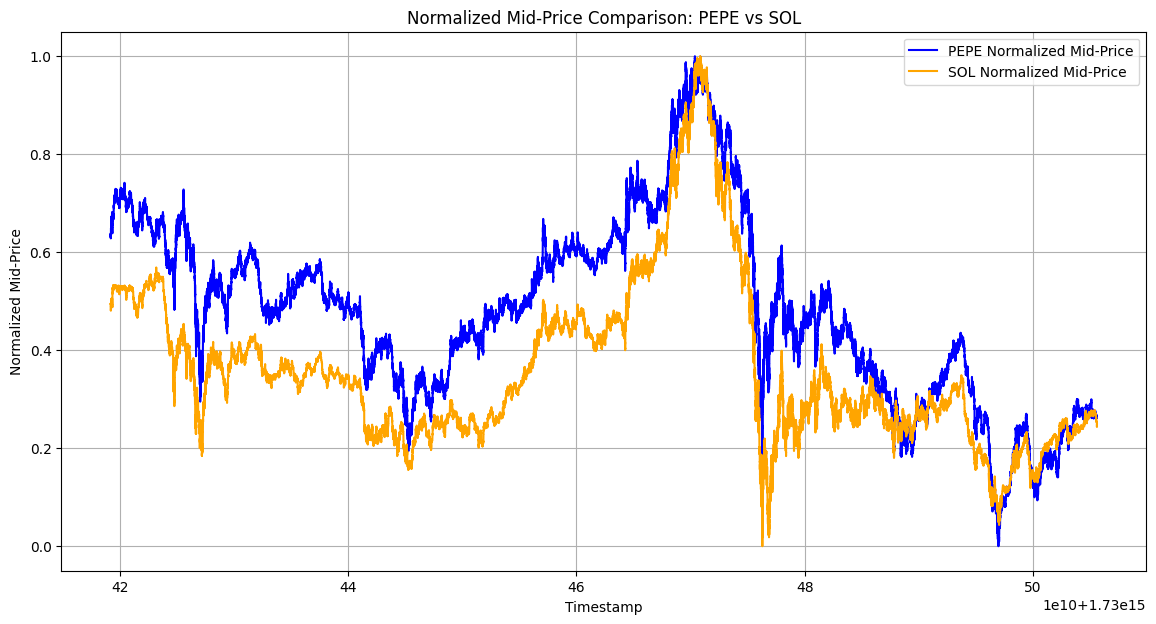

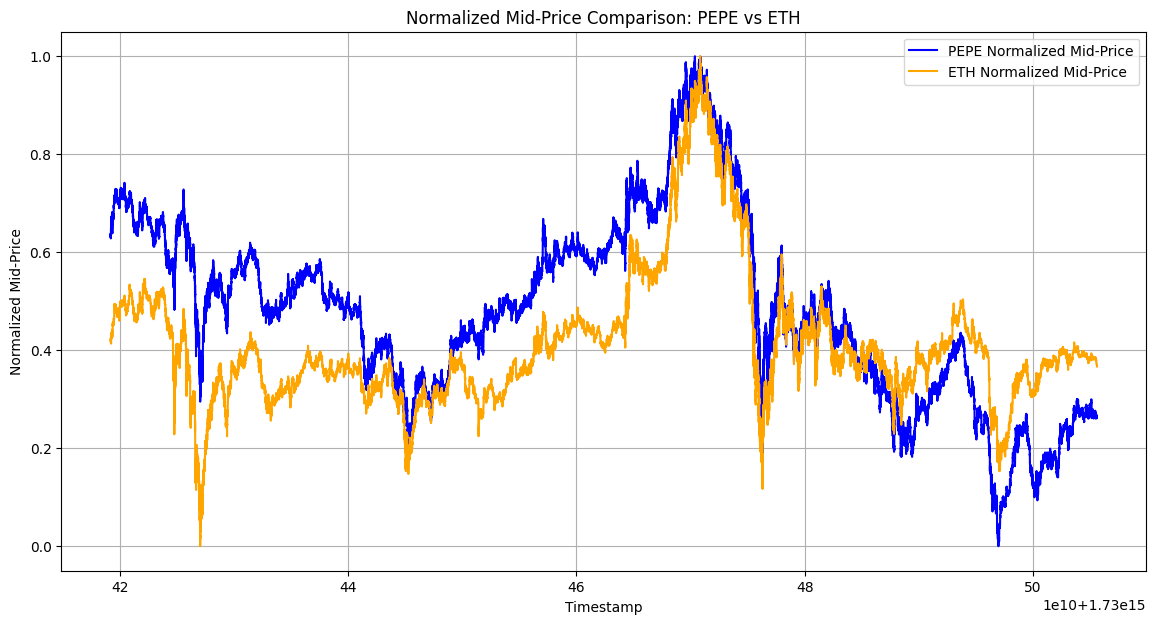

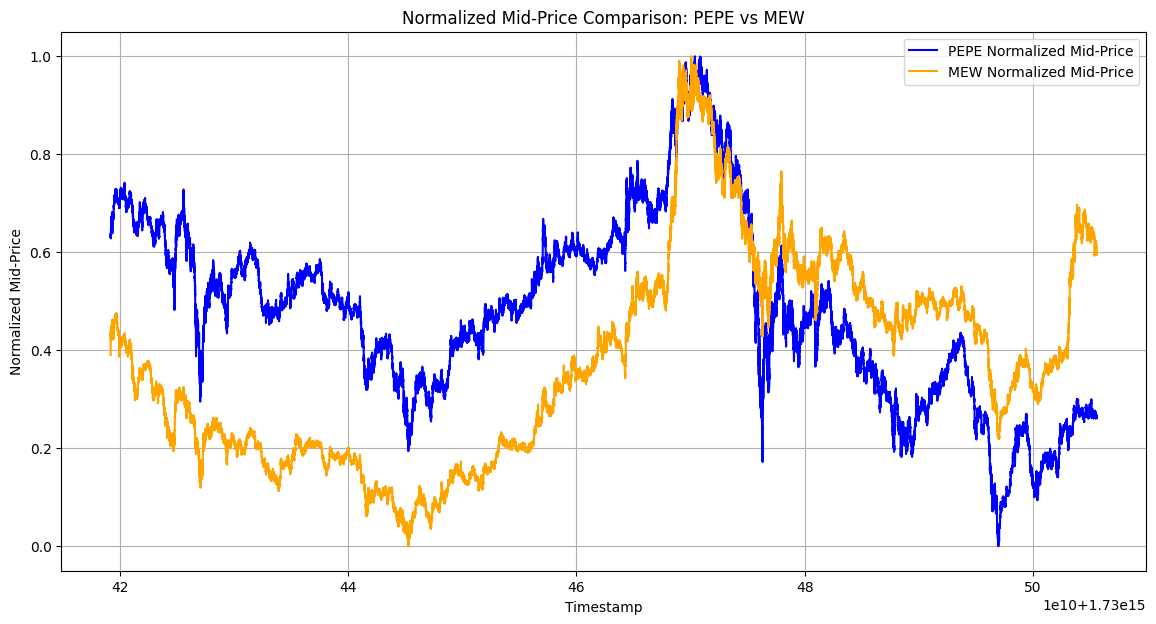

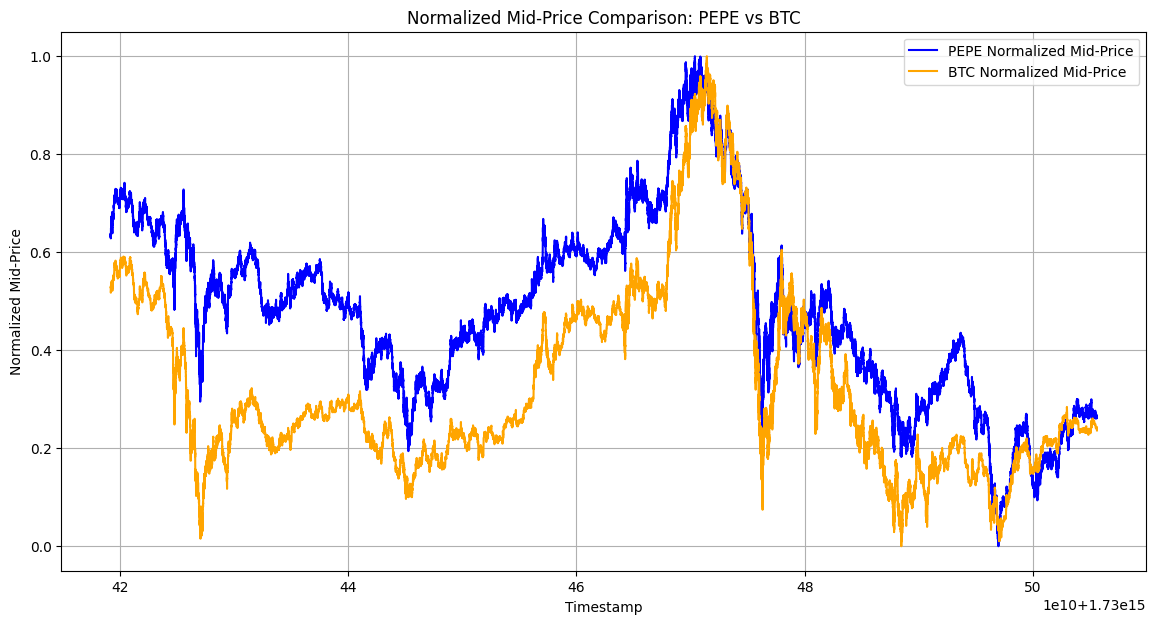

In [30]:
def normalize_series(series):
    return (series - series.min()) / (series.max() - series.min())

# Создание графиков mid-price для пар инструментов
pairs = [
    (df_pepe, 'PEPE', df_sol, 'SOL'),
    (df_pepe, 'PEPE', df_eth, 'ETH'),
    (df_pepe, 'PEPE', df_mew, 'MEW'),
    (df_pepe, 'PEPE', df_btc, 'BTC')
]

for df1, name1, df2, name2 in pairs:
    # Сортировка данных по времени
    df1_sorted = df1.sort_values(by='local_timestamp').copy()
    df2_sorted = df2.sort_values(by='local_timestamp').copy()

    # Нормализация mid-price
    df1_sorted['normalized_mid-price'] = normalize_series(df1_sorted['mid-price'])
    df2_sorted['normalized_mid-price'] = normalize_series(df2_sorted['mid-price'])

    plt.figure(figsize=(14, 7))
    
    # Построение графиков
    plt.plot(df1_sorted['local_timestamp'], df1_sorted['normalized_mid-price'], label=f'{name1} Normalized Mid-Price', color='blue')
    plt.plot(df2_sorted['local_timestamp'], df2_sorted['normalized_mid-price'], label=f'{name2} Normalized Mid-Price', color='orange')
    
    plt.title(f'Normalized Mid-Price Comparison: {name1} vs {name2}')
    plt.xlabel('Timestamp')
    plt.ylabel('Normalized Mid-Price')
    plt.legend()
    plt.grid(True)
    
    # Отображение графика
    plt.show()

**task3**

In [31]:
def calculate_imbalance(df, n):
    total_bids_amount = df[[f'bids[{i}].amount' for i in range(n)]].sum(axis=1)
    total_asks_amount = df[[f'asks[{i}].amount' for i in range(n)]].sum(axis=1)
    imbalance = total_bids_amount / (total_bids_amount + total_asks_amount)

    new_columns = pd.DataFrame({
        f'total_bids_amount[{n}]': total_bids_amount,
        f'total_asks_amount[{n}]': total_asks_amount,
        f'imbalance[{n}]': imbalance
    }, index=df.index)
    
    df = pd.concat([df, new_columns], axis=1)
    return df


n = 24

df_pepe = calculate_imbalance(df_pepe, n)

df_pepe['spread_l1'] = df_pepe['asks[1].price'] - df_pepe['bids[1].price']
df_pepe['mid-price'] = (df_pepe['asks[0].price'] + df_pepe['bids[0].price']) / 2

df_pepe['mid-price_3sec'] = df_pepe['mid-price'].shift(-51000)
df_pepe['target'] = (df_pepe['mid-price_3sec'] - df_pepe['mid-price']) / df_pepe['mid-price']
df_pepe.dropna(subset=['target'], inplace=True)

df_sol['mid-price'] = (df_sol['asks[0].price'] + df_sol['bids[0].price']) / 2
df_pepe['sol_mid-price'] = df_sol['mid-price']

df_sol['mid-price_shifted'] = df_sol['mid-price'].shift(20000)
df_pepe['sol_mid-price_shifted'] = df_sol['mid-price_shifted']

X_3 = df_pepe[[f'imbalance[{n}]']].dropna() 
y = df_pepe['target'] 

X_3.columns = X_3.columns.str.replace(r"[\[\]]", "", regex=True)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_3, y, test_size=0.5, random_state=42)

# Step 7: Define and train model
model3 = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)
model3.fit(X_train, y_train)

# Predict and calculate R^2 score
y_pred_3 = model3.predict(X_test)
r2_3 = metrics.r2_score(y_test, y_pred_3)

print(f"R^2 Score: {r2_3}")




R^2 Score: 0.0012245673523164635


In [32]:

#model4

df_pepe['rsi'] = RSIIndicator(close = df_pepe['mid-price'], window=14).rsi()

macd = MACD(close=df_pepe['mid-price'], window_slow=26, window_fast=12, window_sign=9)
df_pepe['macd'] = macd.macd()
df_pepe['macd_signal'] = macd.macd_signal()


bollinger = BollingerBands(close=df_pepe['mid-price'], window=20, window_dev=2)
df_pepe['bollinger_mavg'] = bollinger.bollinger_mavg()
df_pepe['bollinger_hband'] = bollinger.bollinger_hband()
df_pepe['bollinger_lband'] = bollinger.bollinger_lband()


#X_4 = df_pepe[['sol_mid-price', f'imbalance[{n}]', 'spread_l1']]

                                                                        #'sol_mid-price'
X_4 = df_pepe[[f'imbalance[{n}]','rsi', 'macd', 'macd_signal', 'bollinger_mavg', 'spread_l1', 'sol_mid-price']]
X_train, X_test, y_train, y_test = train_test_split(X_4, y, test_size=0.5)


X_train.columns = X_train.columns.str.replace(r"[<>\[\]]", "", regex=True)
X_test.columns = X_test.columns.str.replace(r"[<>\[\]]", "", regex=True)

model4 = XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=5)

model4.fit(X_train, y_train)
y_pred_4 = model4.predict(X_test)


r2_4 = metrics.r2_score (y_test, y_pred_4)

In [33]:
r2_4

0.5535437621327002

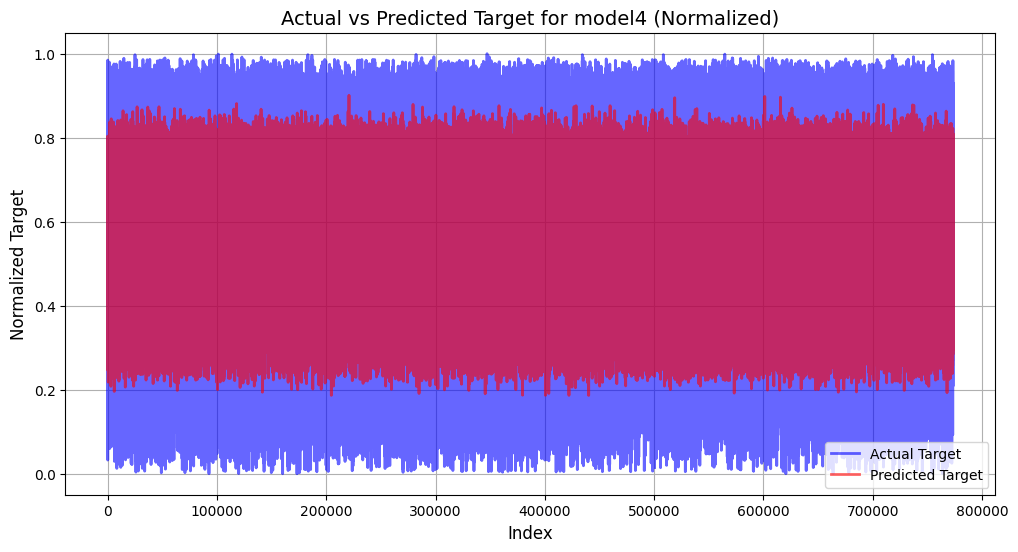

In [18]:
from sklearn.preprocessing import MinMaxScaler

# Нормализация данных для лучшей визуализации
scaler = MinMaxScaler()

# Нормализуем реальные значения и предсказания
y_test_scaled = scaler.fit_transform(y_test.values.reshape(-1, 1))
y_pred_4_scaled = scaler.transform(y_pred_4.reshape(-1, 1))

# Визуализация реального target и предсказанного target
plt.figure(figsize=(12, 6))
plt.plot(y_test_scaled, label='Actual Target', color='blue', alpha=0.6, linewidth=2)
plt.plot(y_pred_4_scaled, label='Predicted Target', color='red', alpha=0.6, linewidth=2)
plt.title('Actual vs Predicted Target for model4 (Normalized)', fontsize=14)
plt.xlabel('Index', fontsize=12)
plt.ylabel('Normalized Target', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()